# Clustering and Classification of MEPs' Tweets

We will investigate a dataset of tweets made by Members of the European Parliament. We will use data collected by Darko Cherepnalkoski, Andreas Karpf, Igor Mozetič, and Miha Grčar for their paper [Cohesion and Coalition Formation in the European Parliament: Roll-Call Votes and Twitter Activities](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0166586).


---
> Vasileios Galanos <br />
> Msc in Data Science (Part-Time) <br />
> 12/2019 <br />
> vgalanos@aueb.gr
---


## Data Preparation
* First we download the dataset from <https://www.clarin.si/repository/xmlui/handle/11356/1071>.
* We will use `retweets.csv` file, which we import to a pandas dataframe.
* Keeping only records for which the language of the original tweet (`lan`) is in English, we create a list with the unique original tweet ids.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

# import csv
df = pd.read_csv('dataset/retweets.csv')

# keep only records in english
df = df.loc[df.lang == 'en']

# create new empty column that we will store the tweet text
df["origTweetText"] = ""

# create a list with the unique original tweet ids
tweet_ids = df.origTweetId.unique().tolist()

* We will use the `tweepy API` to retreive the actual text of the each tweet id.
* After specifying our API credentials, we create a list of lists. Using this iterable object, we will try to fetch 100 tweets with each request to the API.

In [2]:
import tweepy
from twitter_config import config
import time

# Specify credentials
auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth)

# Create list of lists, with 100 ids in each sublist.
tweet_list_ids = [tweet_ids[i:i + 100] for i in range(0, len(tweet_ids), 100)]

* In case that we run into a rate limit, we will catch the exception and wait some time before we try again.
* With `api.statuses_lookup` we can fetch 100 tweets per request, specified by the id parameter

In [3]:
def get_statuses(tw_list):
        try:
            statuses = api.statuses_lookup(tw_list, trim_user=True)
            # This is to avoid running into a rate limit
            #time.sleep(60)
        except tweepy.RateLimitError:
            # But if we do run into a rate limit, then
            # go to sleep for 15 minutes
            print('Rate limit reached')
            time.sleep(15 * 60)
        except tweepy.TweepError as te:
            if te[0]['code'] == '419':
                print('Requests limit reached')
                time.sleep(15 * 60)
            else:
                raise
        return statuses

For each sublist consisting of 100 tweet ids (except the last) in `tweet_ids` list, we fetch the tweet texts and store them to the dataframe column accordingly

In [4]:
# Initiate time measurement
start = time.time()

for i in range(len(tweet_list_ids)):
    if i % 10 == 0:
        print('Processing batch :',i)
    for item in get_statuses(tweet_list_ids[i]):
        if item:
            df.loc[df.origTweetId == item.id,'origTweetText'] = item.text

end = time.time()
m, s = divmod(end - start, 60)

print('Processing time: %.0f minutes' % m,'and %.0f seconds' % s)

Processing batch : 0
Processing batch : 10
Processing batch : 20
Processing batch : 30
Processing batch : 40
Processing batch : 50
Processing batch : 60
Processing batch : 70
Processing batch : 80
Processing batch : 90
Processing batch : 100
Processing time: 1 minutes and 49 seconds


* Next, we keep only the records for which we were able to download the tweet text.
* Also, we group the records by the European group of the MEP that posted the original tweet and drop groups with very few tweets (less than 50)

In [5]:
# drop records with empty tweets
df = df.loc[df.origTweetText != '']

# drop records for parties with few tweets
df = df[df.groupby('origMepGroupId').origTweetText.transform('count')>=50].reset_index()

df.groupby('origMepGroupId').count()['origTweetText'].sort_values(ascending=False)

origMepGroupId
6    3261
1    3039
4    2104
3    1854
2    1195
5    1102
0    353 
Name: origTweetText, dtype: int64

Finally, using regular expressions we remove urls, numeric characters and other symbols that we find of no use for the next step of our investigation

## Clustering

First of all, we need to convert the tweets to a format that is suitable for k-means. We can either use a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or a [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
* We will use `min_df=10` thus when building the vocabulary we ignore terms that have a document frequency strictly lower than 10 (they appear in less than 10 tweets).
* Similarly with `max_df=0.50`,we ignore terms that have a document frequency strictly higher 50%.
* `strip_accents='unicode'` removes accents and perform other character normalization during the preprocessing step.
* `lowercase=True` converts all characters to lowercase before tokenizing
* We tried `TfidfVectorizer` but it didn't have good scores (the elbow method didn't even converged). Generally it deals better with terms in large documents that display higher counts than those of smaller documents even if their topic is the same. In our case though, a tweet has specific maximum characters so all documents have almost the same length, so we will proceed with the `CountVectorizer` instead.
* We use a stopwords list which we downloaded from the [NLTK Data](https://www.nltk.org/data.html), to remove any stopwords from our dataset.
* We will use `ngram_range=(1,1)`. We tested with bi-grams but it didn't produce good results 

In [6]:
# download stopwords from NLTK Data
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# prepare a list with stopwords
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 
stop_words.add('rt') #add RT, for removing the Retweet word

* We use [TextBlob](https://textblob.readthedocs.io/en/dev/), a Python library for processing textual data. We use this library to tokenize and stem our string of words using a Porter Stemmer
* We also clean the tweet from any urls, symbols, and numeric characters.

In [8]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

def textcleaner_tokenizer(str_input):
    str_input_clean = re.sub(r'http\S+','', str(str_input)) #remove urls
    str_input_clean = re.sub(r'&amp;','', str(str_input_clean)) #remove amp (&) special symbol
    str_input_clean = re.sub(r'[^a-zA-Z ]','', str(str_input_clean)) #keep only letters and whitespaces
    blob = TextBlob(str_input_clean.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    filtered_words = [w for w in words if not w in stop_words]
    return filtered_words

count_vect = CountVectorizer(min_df=10
                            ,max_df=0.5
                            ,strip_accents='unicode'
                            ,tokenizer=textcleaner_tokenizer
                            ,ngram_range=(1,1)
                            )

X_count = count_vect.fit_transform(df['origTweetText']) #fit the vectorizer to synopses

print(X_count.shape)

(12908, 2215)


It is time to use the elbow method to find the best number of clusters.
* It utilizes the [yellowbrick](https://www.scikit-yb.org/en/latest/index.html) library to draw the diagram
where the number of clusters is on the $x$ axis and the sum of squared distances from each observation to the centroid of its cluster (the *distortion score*) is on the $y$ axis
* We found an elbow at 7 clusters, but we will keep the scores for later use.

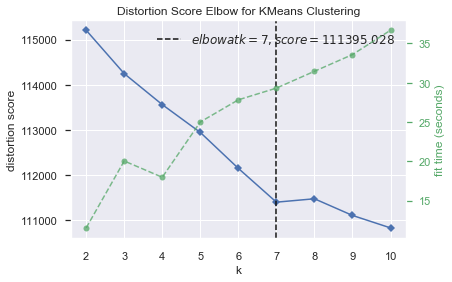

In [155]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=94)
visualizer = KElbowVisualizer(kmeans, k=(2,11))

visualizer.fit(X_count)
visualizer.show()

In [156]:
#keep elbow scores for later use
elbow_scores = visualizer.k_scores_

We will try another method, the [silhouette analysis](https://en.wikipedia.org/wiki/Silhouette_(clustering)) and see if we get the same results

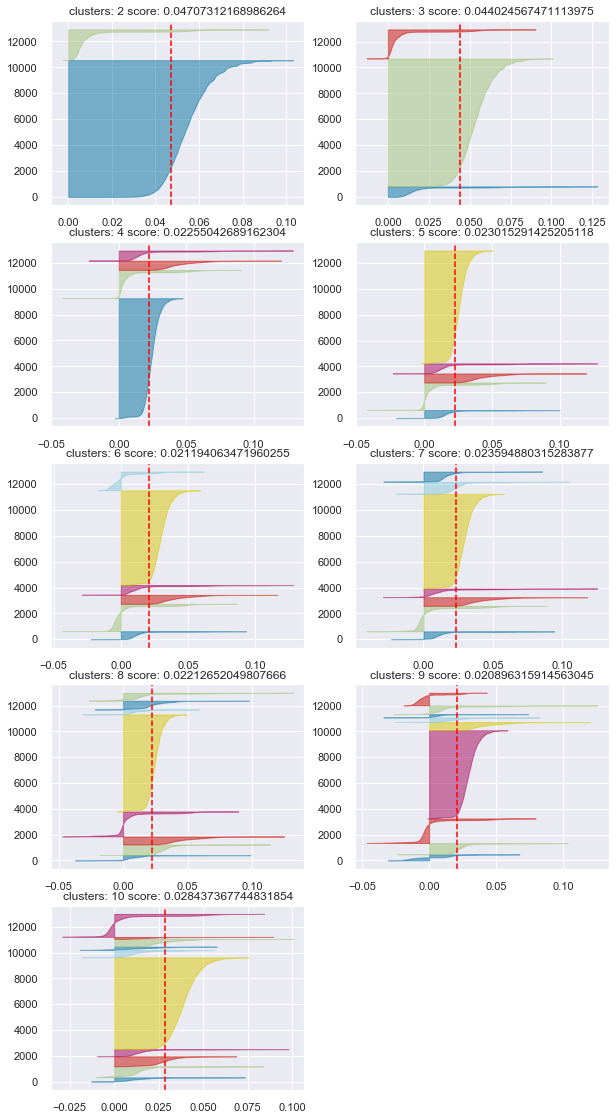

In [157]:
from matplotlib import pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(2 * 5,  10 * 4))

scores = {}
for n_clusters in range(2, 11):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=94)
    visualizer2 = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer2.fit(X_count)
    scores[n_clusters] = visualizer2.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer2.silhouette_score_}')

* Now, we will try to visualize, both elbow and silhouette scores and see where they both flat out.
* From the results, we believe that 7 clusters will be sufficient.

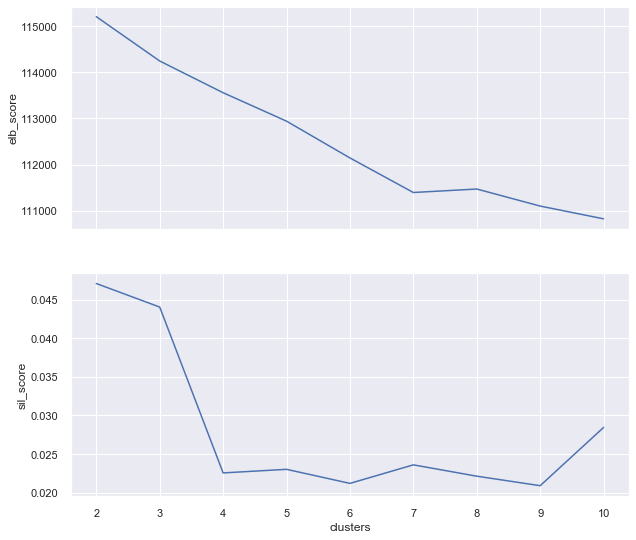

In [158]:
import seaborn as sns; sns.set()

kscores = pd.DataFrame.from_dict(scores, orient='index').reset_index()
kscores = kscores.rename(columns={"index": "clusters", 0: "sil_score"})
kscores['elb_score'] = elbow_scores

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,9))

sns.lineplot(x = 'clusters', y = 'elb_score'
             , data=kscores, ax = ax1)
sns.lineplot(x = 'clusters', y = 'sil_score'
             , data=kscores, ax = ax2)

Unfortunately, this method gives us 2 as the best number of clusters, but the results are not clear as we see. The scores are too close, so we will trust the elbow method and use 6 clusters instead.

* We use the best number of clusters that we found and fit a new model.
* In order to find the most important features in each cluster, we will find the cluster center of each cluster, get the top 20  dimensions and print them out.

In [160]:
number_of_clusters = 7
km_count = KMeans(number_of_clusters, random_state=94)
km_count.fit(X_count)

print("Top terms per cluster:")
order_centroids = km_count.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: europ eppgroup need eu must peopl say ha thi refuge work chang greec togeth support today want fight one futur
Cluster 1: eu uk leav must ha mep need want cameron say us support referendum border today right control britain work membership
Cluster 2: european parliament union eu need eppgroup vote debat commiss today ha ttip want year mep report call uk right us
Cluster 3: vote eu ttip mep ep today labour ukip report debat support tori major eppgroup parliament committe favour ye europarlen right
Cluster 4: today eppgroup meet mep support need great ep peopl good work thank ha debat right europarlen new ttip labour must
Cluster 5: ukip parti vote thi labour today polici ha peopl nh poll onli tori uk mep elect support immigr want campaign
Cluster 6: thi eu morn year peopl week uk great good debat need right meet eppgroup take ha even time must discuss


* The first cluster has topics like Greece and refugees, while the second has topics like Brexit and the Uk generally.
* To better understand the clustering process, we will try to visualize it. We will use use the [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)(Principal Component Analysis) to reduce the dimensions from the length of the vocabulary to only 2, so we will plot in the following graph.

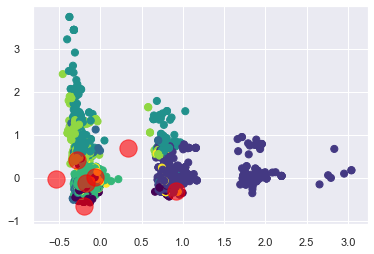

In [161]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import normalize

prediction = km_count.predict(X_count)

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_count.toarray())

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = km_count.cluster_centers_
centers = sklearn_pca.fit_transform(centers)
plt.scatter(centers[:, 0], centers[:, 1],c='red', s=300, alpha=0.6);

It seems that the cluster centers cannot be visualized in two dimensions. That is logical, since the reduction is very extreme and valuable information is lost.

Bellow we see the top terms for every cluster that we found in a `seaborn` barplot.

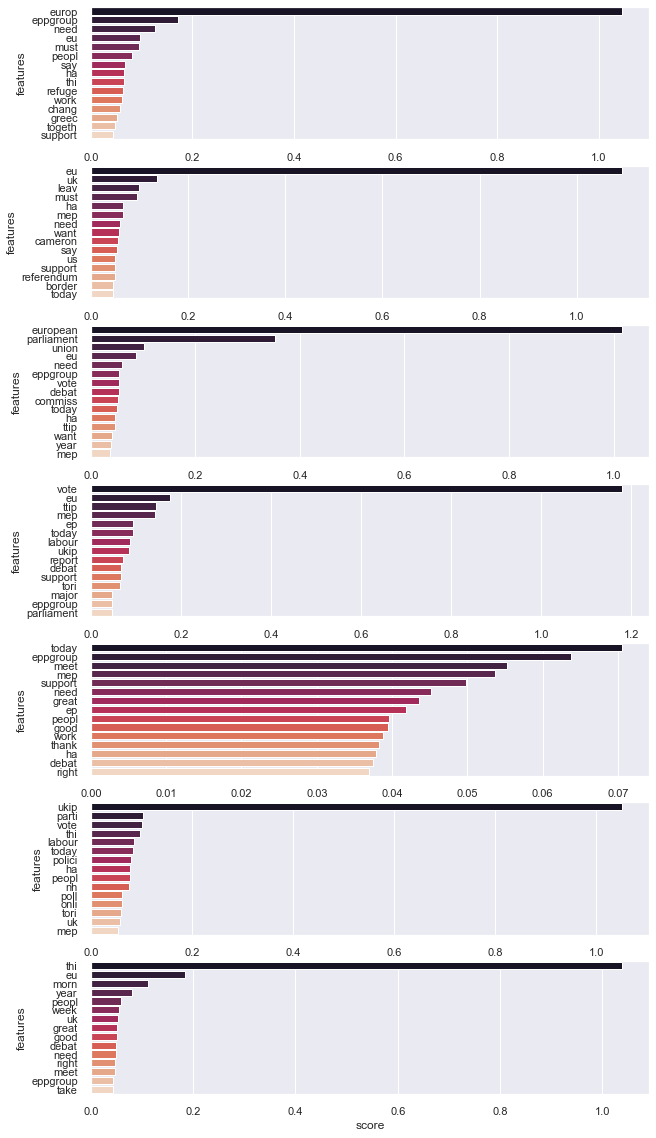

In [162]:
import seaborn as sns

def get_top_features_cluster(X_count_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(X_count_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = count_vect.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(X_count.toarray(), prediction, 15)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(10, 20),nrows=7)
sns.barplot(x="score", y="features", data=dfs[0],
            label="Total", palette="rocket",ax = ax1)
sns.barplot(x="score", y="features", data=dfs[1],
            label="Total", palette="rocket",ax = ax2)
sns.barplot(x="score", y="features", data=dfs[2],
            label="Total", palette="rocket",ax = ax3)
sns.barplot(x="score", y="features", data=dfs[3],
            label="Total", palette="rocket",ax = ax4)
sns.barplot(x="score", y="features", data=dfs[4],
            label="Total", palette="rocket",ax = ax5)
sns.barplot(x="score", y="features", data=dfs[5],
            label="Total", palette="rocket",ax = ax6)
sns.barplot(x="score", y="features", data=dfs[6],
            label="Total", palette="rocket",ax = ax7)

Lastly, we use Yellowbrick's [InterclusterDistance](https://www.scikit-yb.org/en/latest/api/cluster/icdm.html) to visualize the clusters in 2 dimensions with the distance to other centers preserved.
* We don't notice any overlaps and that is a good sign for our clustering.

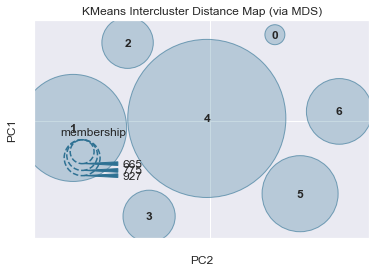

In [163]:
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering model and visualizer
model = KMeans(7, random_state=94)
visualizer = InterclusterDistance(model
                                  ,legend_loc='lower left')

visualizer.fit(X_count)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Classification
In this section, we will train two algorithms, to learn to classify an unseen tweet. The target variable is the political party of the original poster, and the training features are the original tweet's text.
* We will start with a simple `CountVectorizer()`, to get a bag of words (term frequency) representation of our data.
* Next, we use a [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) which is suitable for classification with discrete features (in our case, word counts).
* We divide our data into a training and testing dataset using [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) (66 % training - 33 % testing).
* Our target variable is `origMepGroupId`

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25,shuffle=True, random_state=94)

vectorizer = CountVectorizer(tokenizer=textcleaner_tokenizer)
X_train_counts = vectorizer.fit_transform(train['origTweetText'])

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_counts, train.origMepGroupId)

Using the test dataset, we make predictions for the political parties based on the tweets, and compare them to the actual political parties.

In [11]:
X_test_counts = vectorizer.transform(test['origTweetText'])

predicted = clf.predict(X_test_counts)

np.mean(predicted == test.origMepGroupId)

0.6901146575766967

We can combine all of our components together using a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [12]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer(tokenizer=textcleaner_tokenizer)),
                     ('clf', MultinomialNB()),
                    ])

text_clf.fit(train['origTweetText'], train['origMepGroupId'])
predicted = text_clf.predict(test['origTweetText'])
np.mean(predicted == test.origMepGroupId)   

0.6901146575766967

Now, instead of tweaking the parameters for the various components in our chain, we can simply use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). In that way, we perform an exhaustive search that provides us with the best parameters for our model

In [169]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [ 0.1, 0.2, 0.5 ,0.7],
              'vect__min_df': [1, 10, 50],
              'clf__alpha': (1e-2, 1e-3)
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(train['origTweetText'], train['origMepGroupId'])

print(gs_clf.best_params_)

{'clf__alpha': 0.01, 'vect__max_df': 0.1, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}


Now we use those parameters, to define our optimum model as follows

In [241]:
multi_text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2)
                                             ,max_df = 0.1
                                             ,min_df = 1
                                             ,strip_accents = 'unicode'
                                             ,tokenizer=textcleaner_tokenizer
                                             )),
                     ('clf', MultinomialNB(alpha = 0.01)),
                    ])

multi_text_clf = multi_text_clf.fit(train['origTweetText'], train['origMepGroupId'])
predicted = multi_text_clf.predict(test['origTweetText'])
np.mean(predicted == test.origMepGroupId)  

0.72420204524326

With a [Classification Report](https://scikit-learn.org/0.19/modules/generated/sklearn.metrics.classification_report.html), we can see precision scores for every political party. We can also the scores in other metrics like recall and f1-score.
* Precison means the percentage of our results which are relevant :$Precision = \frac{\textit{True Positive}}{\textit{True Positive} + \textit{False Positive}}$
* while Recall refers to the percentage of total relevant results correctly classified by your algorithm: 
$Recall = \frac{\textit{True Positive}}{\textit{True Positive} + \textit{False Negative}}$. 
Interestingly the worst recall scores came from the parties which had the least tweets, so maybe with a more balanced dataset we may have had better recall scores
* The F1-score combines the previous with a harmonic mean to produce a simpler metric that is easier to work with: $\textit{F1-score} = 2 \times \frac{Precision*Recall}{Precision + Recall}$. We conclude that we don't predict well for tweets from the __European United Left–Nordic Green Left__ and from __European Conservatives and Reformists__.

In [172]:
from sklearn import metrics

party_names = pd.DataFrame(test.groupby(
    ['origMepGroupShort', 'origMepGroupId']).size()).sort_values(by = ['origMepGroupId']
                                                                ).reset_index()
party_names = party_names.origMepGroupShort.values

print(metrics.classification_report(test.origMepGroupId, predicted
                            ,target_names = party_names ))

              precision    recall  f1-score   support

     GUE-NGL       0.64      0.59      0.62        88
         S&D       0.72      0.73      0.72       730
  Greens-EFA       0.63      0.60      0.61       319
        ALDE       0.68      0.68      0.68       484
         EPP       0.77      0.70      0.73       562
         ECR       0.59      0.54      0.56       266
        EFDD       0.81      0.90      0.85       778

    accuracy                           0.72      3227
   macro avg       0.69      0.68      0.68      3227
weighted avg       0.72      0.72      0.72      3227



We can also see the [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
* Interestingly, a lot of tweets from the [S&D](https://en.wikipedia.org/wiki/Progressive_Alliance_of_Socialists_and_Democrats) party are confused to belong to the [EFDD](https://en.wikipedia.org/wiki/Europe_of_Freedom_and_Direct_Democracy) party . 

In [208]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(test.origMepGroupId, predicted, labels = [0, 1, 2, 3, 4, 5, 6])
                ,index = [ 'true: ' + x for x in party_names]
                 ,columns= [ 'pred: ' + x for x in party_names]
                )

,pred: GUE-NGL,pred: S&D,pred: Greens-EFA,pred: ALDE,pred: EPP,pred: ECR,pred: EFDD
true: GUE-NGL,52,7,5,6,7,3,8
true: S&D,7,532,31,44,36,24,56
true: Greens-EFA,3,47,191,27,19,15,17
true: ALDE,5,44,24,330,38,15,28
true: EPP,11,44,33,55,391,19,9
true: ECR,0,40,6,21,8,143,48
true: EFDD,3,27,13,5,7,25,698


* We used a `TfidfTransformer` to _combine term frequency_(tf) with _inverse document frequency_ (idf). This way, we downscaled weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus. Unfortunately, it decreased the accuracy of our model, so we will not use it afterall.

* For the prediction, we use a [SDGClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements regularized linear models with stochastic gradient descent (SGD) learning.

In [228]:
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (1,2)
                                             ,tokenizer=textcleaner_tokenizer
                                             ,max_df = 0.5
                                             ,min_df = 1
                                             ,strip_accents = 'unicode'
                                             )),
                     ('clf', SGDClassifier(max_iter = 6000,tol = 1e-3))
                    ])

text_clf.fit(train['origTweetText'], train['origMepGroupId'])
predicted = text_clf.predict(test['origTweetText'])
np.mean(predicted == test.origMepGroupId)   

0.7229625038735668

In [229]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__penalty': ('l2','l1'),
              'clf__epsilon': (0.1,0.01,0.001,0.0001),
              'clf__alpha': (1e-2, 1e-3)
              
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(train['origTweetText'], train['origMepGroupId'])

print(gs_clf.best_params_)

{'clf__alpha': 0.001, 'clf__epsilon': 0.0001, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2)}


Now we use those parameters, to define our optimum model, and we present the results from the metrics

In [240]:
from sklearn.linear_model import SGDClassifier
sgd_text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2)
                                             ,max_df = 0.1
                                             ,min_df = 1
                                             ,strip_accents = 'unicode'
                                             ,tokenizer=textcleaner_tokenizer
                                             )),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2'
                                           ,alpha = 0.001
                                           ,max_iter = 6000
                                           ,tol = 1e-3
                                           ,epsilon =0.0001
                                           ,random_state = 94
                                          )),
                    ])

sgd_text_clf = sgd_text_clf.fit(train['origTweetText'], train['origMepGroupId'])
predicted = sgd_text_clf.predict(test['origTweetText'])

print(metrics.classification_report(test.origMepGroupId, predicted
                            ,target_names = party_names ))

              precision    recall  f1-score   support

     GUE-NGL       0.83      0.55      0.66        88
         S&D       0.71      0.76      0.73       730
  Greens-EFA       0.65      0.56      0.60       319
        ALDE       0.72      0.68      0.70       484
         EPP       0.79      0.72      0.75       562
         ECR       0.65      0.53      0.58       266
        EFDD       0.76      0.91      0.82       778

    accuracy                           0.73      3227
   macro avg       0.73      0.67      0.69      3227
weighted avg       0.73      0.73      0.73      3227



Indeed, using the `SGDClassifier` produced better results. Now, on to the confusion matrix:

In [231]:
pd.DataFrame(confusion_matrix(test.origMepGroupId, predicted, labels = [0, 1, 2, 3, 4, 5, 6])
                ,index = [ 'true: ' + x for x in party_names]
                 ,columns= [ 'pred: ' + x for x in party_names]
                )

,pred: GUE-NGL,pred: S&D,pred: Greens-EFA,pred: ALDE,pred: EPP,pred: ECR,pred: EFDD
true: GUE-NGL,48,8,6,4,8,3,11
true: S&D,4,553,23,34,34,17,65
true: Greens-EFA,2,52,178,23,20,13,31
true: ALDE,1,40,25,330,31,19,38
true: EPP,2,47,24,46,403,14,26
true: ECR,0,40,5,15,8,141,57
true: EFDD,1,36,11,8,5,11,706


Lastly, we will try a Random Forest Classifier to see if we get better results

In [13]:
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (1,2)
                                             ,tokenizer=textcleaner_tokenizer
                                             ,max_df = 0.5
                                             ,min_df = 1
                                             ,strip_accents = 'unicode'
                                             )),
                     ('clf', RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2, random_state=94
                                                   #,cv = cv)
                     ))
                    ])

text_clf.fit(train['origTweetText'], train['origMepGroupId'])
predicted = text_clf.predict(test['origTweetText'])
np.mean(predicted == test.origMepGroupId)   

0.6932135110009296

We will perform a GridSearch to find the best hyperparameters

In [14]:
from sklearn.model_selection import GridSearchCV
parameters = {
            'clf__bootstrap': [True],
            'clf__max_depth': [20, 50, 100, 200],
            'clf__n_estimators': [10,50,100, 200, 300, 1000]
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=3, verbose = 2)
gs_clf = gs_clf.fit(train['origTweetText'], train['origMepGroupId'])

print(gs_clf.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.4min finished


{'clf__bootstrap': True, 'clf__max_depth': 200, 'clf__n_estimators': 1000}


And use the optimal parameters to our pipeline

In [18]:
rf_text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2)
                                             ,max_df = 0.1
                                             ,min_df = 1
                                             ,strip_accents = 'unicode'
                                             ,tokenizer=textcleaner_tokenizer
                                             )),
                     ('clf', RandomForestClassifier(n_estimators=1000
                                                    , max_depth=200
                                                    ,bootstrap=True
                                                    , random_state=94
                                          )),
                    ])

rf_text_clf = rf_text_clf.fit(train['origTweetText'], train['origMepGroupId'])
predicted = rf_text_clf.predict(test['origTweetText'])

print(metrics.classification_report(test.origMepGroupId, predicted
                            ,target_names = party_names ))

              precision    recall  f1-score   support

     GUE-NGL       0.90      0.40      0.55        88
         S&D       0.59      0.76      0.66       730
  Greens-EFA       0.87      0.42      0.57       319
        ALDE       0.83      0.55      0.66       484
         EPP       0.78      0.69      0.73       562
         ECR       0.93      0.34      0.50       266
        EFDD       0.64      0.95      0.76       778

    accuracy                           0.69      3227
   macro avg       0.79      0.59      0.63      3227
weighted avg       0.73      0.69      0.67      3227



Still, it is no better than the `SGDClassifier`

In [238]:
pd.DataFrame(confusion_matrix(test.origMepGroupId, predicted, labels = [0, 1, 2, 3, 4, 5, 6])
                ,index = [ 'true: ' + x for x in party_names]
                 ,columns= [ 'pred: ' + x for x in party_names]
                )

,pred: GUE-NGL,pred: S&D,pred: Greens-EFA,pred: ALDE,pred: EPP,pred: ECR,pred: EFDD
true: GUE-NGL,23,24,1,0,4,0,36
true: S&D,0,564,0,2,17,0,147
true: Greens-EFA,0,110,79,6,16,0,108
true: ALDE,0,122,0,189,32,0,141
true: EPP,0,119,2,11,338,1,91
true: ECR,0,74,0,5,4,68,115
true: EFDD,0,36,0,0,1,0,741


To compare our models, we use a [DummyClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that predicts using a very simple model. It uses the  training set’s class distribution to make predictions. in our case it will predict the political party that had the most tweets (EFDD) for any input that we give. Given that we train this baseline model, and present the results:

In [239]:
from sklearn.dummy import DummyClassifier

dummy_text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2)
                                             ,max_df = 0.5
                                             ,min_df = 1
                                             ,tokenizer=textcleaner_tokenizer
                                             ,strip_accents = 'unicode'
                                             )),
                     ('clf', DummyClassifier(strategy="most_frequent")),
                    ])

dummy_text_clf = dummy_text_clf.fit(train['origTweetText'], train['origMepGroupId'])
dummy_predicted = dummy_text_clf.predict(test['origTweetText'])

print(metrics.classification_report(test.origMepGroupId, dummy_predicted
                            ,target_names = party_names ))

              precision    recall  f1-score   support

     GUE-NGL       0.00      0.00      0.00        88
         S&D       0.00      0.00      0.00       730
  Greens-EFA       0.00      0.00      0.00       319
        ALDE       0.00      0.00      0.00       484
         EPP       0.00      0.00      0.00       562
         ECR       0.00      0.00      0.00       266
        EFDD       0.24      1.00      0.39       778

    accuracy                           0.24      3227
   macro avg       0.03      0.14      0.06      3227
weighted avg       0.06      0.24      0.09      3227



C:\Users\M.GALANOS\Anaconda3\envs\twitterenv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In Conclusion, our best model was the one that used a `SGDClassifier()` and tuned by the best hyperparameters from `GridSearch` , closely followed by the model that used `MultinomialNB()`. The `DummyClassifier()` was seriously outscored by the previous three.